**Estudiante:** Adriana Castillo

# El modelo epidémico de SIR
Una descripción matemática simple de la propagación de una enfermedad en una población es el llamado modelo SIR, que divide la población (fija) de N individuos en tres "compartimentos" que pueden variar en función del tiempo, t:

* S(t) son aquellos susceptibles pero aún no infectados con la enfermedad;
* I(t) es el número de individuos infecciosos;
* R(t) son aquellas personas que se han recuperado de la enfermedad y ahora tienen inmunidad.

El modelo SIR describe el cambio en la población de cada uno de estos compartimentos en términos de dos parámetros,  beta y  gamma.  
- Beta describe la tasa de contacto efectiva de la enfermedad: un individuo infectado entra en contacto con  beta*N otros individuos por unidad de tiempo (de los cuales la fracción que es susceptible a contraer la enfermedad es S/N).  
- Gamma es la tasa de recuperación promedio: es decir, 1/ gamma es el período de tiempo promedio durante el cual una persona infectada puede transmitirlo.

Las ecuaciones diferenciales que describen este modelo fueron derivadas primero por Kermack y McKendrick [ Proc. R. Soc. A , 115 , 772 (1927)]:

\begin{align*}
\frac{\mathrm{d}S}{\mathrm{d}t} &= -\frac{\beta S I}{N},\\
\frac{\mathrm{d}I}{\mathrm{d}t} &= \frac{\beta S I}{N} - \gamma I,\\
\frac{\mathrm{d}R}{\mathrm{d}t} &= \gamma I.
\end{align*}

El siguiente código de Python integra estas ecuaciones para una enfermedad caracterizada por los parámetros  beta=0.2, gamma=10  en una población de N=1000 (quizás 'gripe en una escuela ) El modelo se inicia con una sola persona infectada el día 0: I(0)=1. Las curvas trazadas de S(t), I(t) y R(t) están diseñadas para verse un poco mejor que los valores predeterminados de Matplotlib.

## Generar la prediccion del modelos SIR

 Se debe  estimar el valor de 
- β 
- γ

Para ajustar el modelo SIR con los casos confirmados reales (el número de personas infecciosas) del Ecuador.
 
 Para ello deben seguir el siguiente tutorial 
 https://www.lewuathe.com/covid-19-dynamics-with-sir-model.html
 


In [5]:
# Implementar y explicar la predicion del modelo SIR para el Ecuador

# 1. Implementar solo teniendo en cuenta los casos confirmados

# 2. Implementar teniendo en cuenta los casos confirmados y recuperados.


import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from sklearn import linear_model
import matplotlib.pyplot as plt



df = pd.read_csv('Covid_Ec.csv',sep=';')
FMT = '%d/%m/%Y'
date = df['date']
df['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("31/12/2019", FMT)).days)
df

,date,Ecuador,Recuperados
0,0,0,0
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,0
...,...,...,...
99,99,3995,140
100,100,4450,339
101,101,4965,368
102,102,7161,411


In [6]:
x = list(df.iloc [:, 0]) # Fecha
y = list(df.iloc [:, 1]) # Numero de casos
def  exponencial ( x ,  a ,  b ,  c ): 
    return a * np . exp ( - b * x ) + c
exp_fit = curve_fit ( exponencial ,  x ,  y ,  p0 = ( 1 ,  1e-6 ,  1 ))
print(exp_fit)

(array([  0.10405587,  -0.10808026, -45.08860463]), array([[ 9.98025647e-04,  9.58601471e-05, -3.72344129e-01],
       [ 9.58601471e-05,  9.22611026e-06, -3.45833098e-02],
       [-3.72344129e-01, -3.45833098e-02,  5.98593647e+02]]))


Casos en el día 120: 44659.6981080675


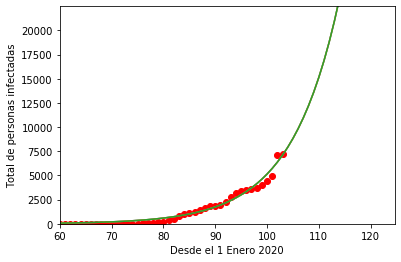

In [7]:
pred_x = list(range(min(x),max(x)+100)) # Predecir 70 dias mas
plt.scatter(x,y,label="Datos Reales",color="red")
# Predicted exponential curve
plt.plot(pred_x, [exponencial(i,exp_fit[0][0],exp_fit[0][1],c= ( 1 ,  1e-6 ,  1 )) for i in pred_x], label="Modelo Exponencial" )
plt.xlabel("Desde el 1 Enero 2020")
plt.ylabel("Total de personas infectadas")
plt.xlim(60, max(x)*1.21)
plt.ylim(0, max(y)*3.1)

casos=pred_x, [exponencial(i,exp_fit[0][0],exp_fit[0][1],c= ( 1 ,  1e-6 ,  1 )) for i in pred_x]
print('Casos en el día 120:',casos[1][120][0])
plt.show()

In [75]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

data=list(df.iloc[:,1])
                                                                    

poblacion=44000
i0=44659
r0=0
s0=poblacion - i0 - r0
        
def loss(point, data):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s0,i0,r0], t_eval=np.arange(0, size, 1), vectorized=True)
    return np.sqrt(np.mean((solution.y[1] - data)**2))

optimal = minimize(loss,[0.001, 0.001],args=(data),method='L-BFGS-B',bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])
betaS,gamaS=optimal.x
print(betaS)
print(gamaS)

0.012123624848145062
0.4


0.012123624848145062
0.4


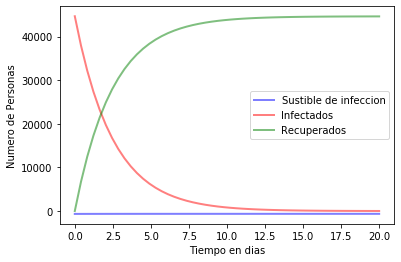

In [76]:
#Importar las librerias.
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Total de la poblacion
N = poblacion
# Numero Inicial de Infectados
I0 = i0
# Numero de Recuperados
R0 = r0
# Todos los demás, S0, son susceptibles a la infección inicialmente.
S0 = N - I0 - R0
# Tasa de contacto, beta (nivel de repoductividad del virus) 
# La tasa de recuperación media, gamma,(1/días) Una persona se recupera en 15 dias.
beta, gamma = betaS,gamaS 
# Una cuadrícula de puntos de tiempo (en días)
t = np.linspace(0, 20, 50)


# Las ecuaciones diferenciales del modelo SIR..
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N 
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Vector de condiciones iniciales
y0 = S0, I0, R0
# Integre las ecuaciones SIR en la cuadrícula de tiempo, t. A traves de la funcion odeint()
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T # Obtenicion de resultados


#  Trace los datos en tres curvas separadas para S (t), I (t) y R (t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111,  axisbelow=True)
ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Sustible de infeccion')
ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infectados')
ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recuperados')
ax.set_xlabel('Tiempo en dias')
ax.set_ylabel('Numero de Personas')
#ax.set_ylim(0,N*1.2)
#ax.yaxis.set_tick_params(length=0)
#ax.xaxis.set_tick_params(length=0)
#ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
#legend.get_frame().set_alpha(0.5)
#for spine in ('top', 'right', 'bottom', 'left'):
#    ax.spines[spine].set_visible(False)
#plt.show()

#Ro = beta/gamma
#print(Ro)
print(beta)
print(gamma)


## Calculos de incidencia

Para obtener metricas de incidencia se debe calcular la tasa de prevalencia, incidencia y la relacion, para esto leer y obtener estos datos con la ultima lectura.

https://www.paho.org/hq/index.php?option=com_content&view=article&id=14402:indicadores-de-salud-aspectos-conceptuales-y-operativos-seccion-2&catid=9894&limitstart=2&Itemid=101&lang=es

In [25]:
# Implementar
def incidencia(nuevos,riesgo,n):
    return (nuevos/riesgo)*pow(10,n)

def prevalencia(casos,poblacion,n):
    return (casos/poblacion)*pow(10,n)

def relacion(incidencia,tiempo):
    return incidencia*tiempo

inci=incidencia(2292,22649,5)
prev=prevalencia(134,636.996,5)
rela=relacion(inci,28)

print('Tasa de Incidencia: ',inci)
print('Tasa de Prevalencia: ',prev)
print('Relación: ',rela)

Tasa de Incidencia:  10119.652081769615
Tasa de Prevalencia:  21036.23884608381
Relación:  283350.2582895492


## Analisis

## Conclusiones

## Opinion

# Referencias:
- https://www.agenciasinc.es/Reportajes/Un-modelo-un-teorema-y-teoria-de-juegos-contra-el-coronavirus
- https://rpubs.com/dsfernandez/422937
- https://towardsdatascience.com/modelling-the-coronavirus-epidemic-spreading-in-a-city-with-python-babd14d82fa2